In [1]:
from __future__ import division
#
import os, sys
sys.path.append(os.getcwd()+'/..')
#
from supports._setting import individual_detail_dir
from supports.charts import x_twin_chart
from supports.handling_pkl import load_picle_file
#
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from prettytable import PrettyTable
from supports.charts import horizontal_bar_chart
#
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
def difference(data0, data1):
    diff = {}
    for k, v in data0.iteritems():
        diff[k] = data1[k] - v
    return diff

def ordering(dids_values):
    order_v_did = []
    for did, v in dids_values.iteritems():
        order_v_did.append([v, did])
    order_v_did.sort()
    order_v_did.reverse()
    return order_v_did

def find_extreme_range(order_v_did):
    # more than mean's 50 percent
    values = [v for v, _ in order_v_did]
    mu, std = np.mean(values), np.std(values)
    i = 0
    while order_v_did[i][0] > mu + std * 2.0:
        i+=1
    return (0, i / len(order_v_did))

def find_negative_range(order_v_did):
    i = 0
    while order_v_did[i][0] >= 0:
        i+=1
    return (i / len(order_v_did), 1.0)

def display_main_group(data_ranges, main_group_data):
    hg_value, mg_value, lg_value = main_group_data
    high_group_range, middle_group_range, low_group_range = data_ranges
    _table = PrettyTable(["Main group", "M Per", "M AVG"])
    _table.align["M Per"] = "r"
    _table.align["M AVG"] = "r"
    for i, g_name in enumerate(['Extreme', 'Middle', 'Negative']):
                _table.add_row([g_name, 
                                '%.2f' %((data_ranges[i][1] - data_ranges[i][0])*100),
                                '%.2f' % (sum(main_group_data[i])/len(main_group_data[i]))])
    print _table
    
def display_sub_group(sub_group_data):
    _table = PrettyTable(["Main","Sub", "S Per", "S AVG"])
    _table.align["S Per"] = "r"
    _table.align["S AVG"] = "r"
    m_g_names = ['Extreme', 'Middle', 'Negative']
    for i, (pg_value, ng_value) in enumerate(sub_group_data):
        main_g_name = m_g_names[i]
        _table.add_row([main_g_name, 'Positive', 
                        '%.2f' % (len(pg_value)/(len(pg_value) + len(ng_value))* 100),
                        '%.2f' % (sum(pg_value)/len(pg_value))])
        _table.add_row([main_g_name, 'Negative', 
                        '%.2f' % (len(ng_value)/(len(pg_value) + len(ng_value))* 100),
                        '%.2f' % (sum(ng_value)/len(ng_value))])
        _table.add_row([main_g_name, 'Summary', 
                        '',
                        '%.2f' % (sum(pg_value + ng_value)/len(pg_value + ng_value))])
    print _table

    
def grouping(data_ranges, values_keys):
    high_group_range, middle_group_range, low_group_range = data_ranges
    total_num = len(values_keys)
    high_group = values_keys[int(high_group_range[0] * total_num):int(high_group_range[1] * total_num)]
    middle_group = values_keys[int(middle_group_range[0] * total_num):int(middle_group_range[1] * total_num)]
    low_group = values_keys[int(low_group_range[0] * total_num):int(low_group_range[1] * total_num)]
    #
    hg_value, hg_did = zip(*high_group)
    mg_value, mg_did = zip(*middle_group)
    lg_value, lg_did = zip(*low_group)
    return hg_value, hg_did, mg_value, mg_did, lg_value, lg_did

def sub_grouping(main_group_keys, _sub):
    sub_group_data = []
    for keys in main_group_keys:
        pg_value, ng_value = [], []
        for k in keys:
            v = _sub[k]
            if v >= 0:
                pg_value.append(v)
            else:
                ng_value.append(v)
        sub_group_data.append([pg_value, ng_value])
    return sub_group_data

In [3]:
both_years_full_drivers,\
Y09_driver_genprod_hour, Y10_driver_genprod_hour, \
Y09_pin_driver_aprod_hour, Y10_pin_driver_aprod_hour, \
Y09_pout_driver_aprod_hour, Y10_pout_driver_aprod_hour, \
Y09_pin_driver_epro_month, Y10_pin_driver_epro_month, \
Y09_pout_driver_epro_month, Y10_pout_driver_epro_month = load_picle_file('%s/productivities_ext.pkl' % (individual_detail_dir))

In [4]:
diff_general_prod = difference(Y09_driver_genprod_hour, Y10_driver_genprod_hour)
diff_pin_prod = difference(Y09_pin_driver_aprod_hour, Y10_pin_driver_aprod_hour)
diff_pout_prod = difference(Y09_pout_driver_aprod_hour, Y10_pout_driver_aprod_hour)
diff_pin_eco = difference(Y09_pin_driver_epro_month, Y10_pin_driver_epro_month)
diff_pout_eco = difference(Y09_pout_driver_epro_month, Y10_pout_driver_epro_month)
diffs ={'diff_g_prod' : diff_general_prod,
        'diff_apin_prod' : diff_pin_prod,
        'diff_apout_prod' : diff_pout_prod,
        'diff_apin_eco' : diff_pin_eco, 
        'diff_apout_eco' :  diff_pout_eco}

In [16]:
def f1(main_st):
    main_diff = diffs[main_st]
    order_v_did = ordering(main_diff)
    main_values = [v for v, _ in order_v_did]
    print main_st, 'AVG: ', np.mean(main_values), 'STD: ', np.std(main_values)
    high_group_range, middle_group_range, low_group_range = find_extreme_range(order_v_did), (0.45, 0.55), find_negative_range(order_v_did)
    data_ranges = [high_group_range, middle_group_range, low_group_range]
    hg_value, hg_did, mg_value, mg_did, lg_value, lg_did = grouping(data_ranges, order_v_did)
    main_group_data = [hg_value, mg_value, lg_value]
    main_group_keys = [hg_did, mg_did, lg_did]
    display_main_group(data_ranges, main_group_data)
    horizontal_bar_chart('','',main_values)
    #
    for sub_st, sub_diff in diffs.iteritems():
        if sub_st == main_st: continue
        print sub_st
        sub_group_data = sub_grouping(main_group_keys, sub_diff)
        display_sub_group(sub_group_data)

diff_g_prod AVG:  2.35671208074 STD:  2.84758526151
+------------+-------+-------+
| Main group | M Per | M AVG |
+------------+-------+-------+
|  Extreme   |  1.29 | 15.85 |
|   Middle   | 10.00 |  2.22 |
|  Negative  |  8.52 | -1.92 |
+------------+-------+-------+
diff_apout_prod
+----------+----------+-------+-------+
|   Main   |   Sub    | S Per | S AVG |
+----------+----------+-------+-------+
| Extreme  | Positive | 72.41 |  6.49 |
| Extreme  | Negative | 27.59 | -4.59 |
| Extreme  | Summary  |       |  3.43 |
|  Middle  | Positive | 73.78 |  4.26 |
|  Middle  | Negative | 26.22 | -3.97 |
|  Middle  | Summary  |       |  2.10 |
| Negative | Positive | 67.71 |  4.07 |
| Negative | Negative | 32.29 | -4.38 |
| Negative | Summary  |       |  1.34 |
+----------+----------+-------+-------+
diff_apin_prod
+----------+----------+-------+-------+
|   Main   |   Sub    | S Per | S AVG |
+----------+----------+-------+-------+
| Extreme  | Positive | 89.66 |  3.09 |
| Extreme  | Negativ

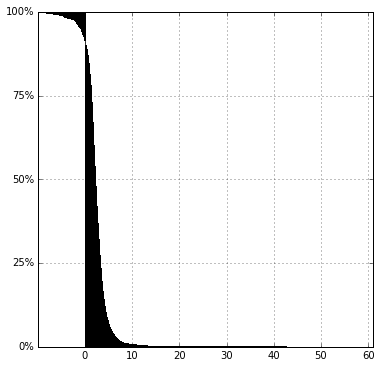

In [17]:
# General productivity difference
f1('diff_g_prod')


diff_apin_prod AVG:  1.6232765514 STD:  4.42278241421
+------------+-------+-------+
| Main group | M Per | M AVG |
+------------+-------+-------+
|  Extreme   |  2.22 | 15.26 |
|   Middle   | 10.00 |  1.86 |
|  Negative  | 22.94 | -3.55 |
+------------+-------+-------+
diff_apout_prod
+----------+----------+-------+-------+
|   Main   |   Sub    | S Per | S AVG |
+----------+----------+-------+-------+
| Extreme  | Positive | 68.00 | 12.16 |
| Extreme  | Negative | 32.00 | -6.36 |
| Extreme  | Summary  |       |  6.23 |
|  Middle  | Positive | 80.89 |  3.92 |
|  Middle  | Negative | 19.11 | -3.70 |
|  Middle  | Summary  |       |  2.46 |
| Negative | Positive | 60.54 |  5.08 |
| Negative | Negative | 39.46 | -6.05 |
| Negative | Summary  |       |  0.68 |
+----------+----------+-------+-------+
diff_g_prod
+----------+----------+-------+-------+
|   Main   |   Sub    | S Per | S AVG |
+----------+----------+-------+-------+
| Extreme  | Positive | 94.00 |  2.82 |
| Extreme  | Negative

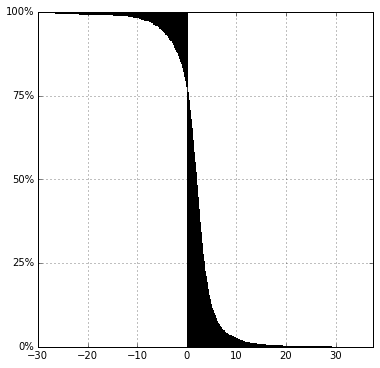

In [18]:
# Airport in productivity difference
f1('diff_apin_prod')

diff_apout_prod AVG:  1.99940717284 STD:  6.61228147191
+------------+-------+-------+
| Main group | M Per | M AVG |
+------------+-------+-------+
|  Extreme   |  2.75 | 21.88 |
|   Middle   | 10.00 |  2.22 |
|  Negative  | 25.82 | -5.21 |
+------------+-------+-------+
diff_g_prod
+----------+----------+-------+-------+
|   Main   |   Sub    | S Per | S AVG |
+----------+----------+-------+-------+
| Extreme  | Positive | 96.77 |  4.04 |
| Extreme  | Negative |  3.23 | -3.14 |
| Extreme  | Summary  |       |  3.81 |
|  Middle  | Positive | 92.44 |  2.57 |
|  Middle  | Negative |  7.56 | -1.03 |
|  Middle  | Summary  |       |  2.30 |
| Negative | Positive | 89.35 |  2.53 |
| Negative | Negative | 10.65 | -1.93 |
| Negative | Summary  |       |  2.05 |
+----------+----------+-------+-------+
diff_apin_prod
+----------+----------+-------+-------+
|   Main   |   Sub    | S Per | S AVG |
+----------+----------+-------+-------+
| Extreme  | Positive | 74.19 |  6.76 |
| Extreme  | Negativ

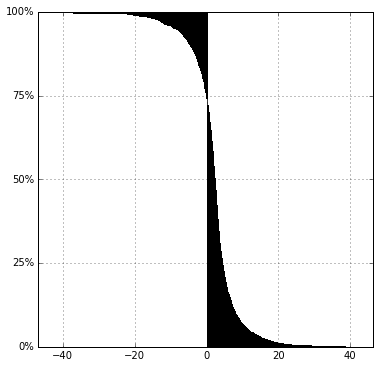

In [22]:
# Airport out productivity difference
f1('diff_apout_prod')

diff_apin_eco AVG:  14.7231472204 STD:  25.998372007
+------------+-------+--------+
| Main group | M Per |  M AVG |
+------------+-------+--------+
|  Extreme   |  2.35 |  93.81 |
|   Middle   | 10.00 |  13.28 |
|  Negative  | 24.31 | -14.61 |
+------------+-------+--------+
diff_apout_prod
+----------+----------+-------+-------+
|   Main   |   Sub    | S Per | S AVG |
+----------+----------+-------+-------+
| Extreme  | Positive | 75.47 |  4.49 |
| Extreme  | Negative | 24.53 | -3.50 |
| Extreme  | Summary  |       |  2.53 |
|  Middle  | Positive | 72.89 |  4.60 |
|  Middle  | Negative | 27.11 | -5.67 |
|  Middle  | Summary  |       |  1.82 |
| Negative | Positive | 72.26 |  4.63 |
| Negative | Negative | 27.74 | -4.83 |
| Negative | Summary  |       |  2.01 |
+----------+----------+-------+-------+
diff_g_prod
+----------+----------+-------+-------+
|   Main   |   Sub    | S Per | S AVG |
+----------+----------+-------+-------+
| Extreme  | Positive | 88.68 |  3.56 |
| Extreme  | Ne

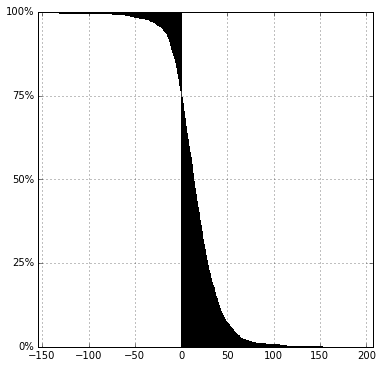

In [19]:
# Airport in eco difference
f1('diff_apin_eco')

diff_apout_eco AVG:  12.2987337466 STD:  74.4662490402
+------------+-------+--------+
| Main group | M Per |  M AVG |
+------------+-------+--------+
|  Extreme   |  3.55 | 263.66 |
|   Middle   | 10.00 |   3.82 |
|  Negative  | 41.79 | -31.75 |
+------------+-------+--------+
diff_apout_prod
+----------+----------+-------+-------+
|   Main   |   Sub    | S Per | S AVG |
+----------+----------+-------+-------+
| Extreme  | Positive | 87.50 |  3.95 |
| Extreme  | Negative | 12.50 | -2.80 |
| Extreme  | Summary  |       |  3.10 |
|  Middle  | Positive | 76.89 |  4.54 |
|  Middle  | Negative | 23.11 | -4.54 |
|  Middle  | Summary  |       |  2.44 |
| Negative | Positive | 58.17 |  3.31 |
| Negative | Negative | 41.83 | -5.90 |
| Negative | Summary  |       | -0.54 |
+----------+----------+-------+-------+
diff_g_prod
+----------+----------+-------+-------+
|   Main   |   Sub    | S Per | S AVG |
+----------+----------+-------+-------+
| Extreme  | Positive | 82.50 |  3.02 |
| Extreme  | 

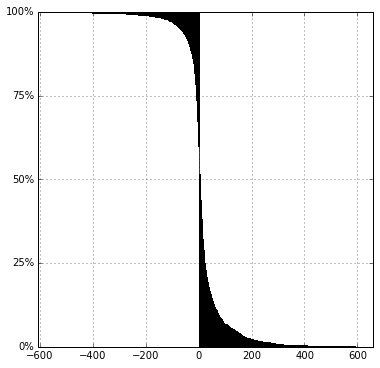

In [20]:
# Airport out eco difference
f1('diff_apout_eco')